### Importing the libraries, functions, and classes from libraries (also autoreload):

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from xrayproject.utils_DAM import load_train, load_masks
from xrayproject.preprocessing import normalize, flip_resize, resize_test
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix

### Loading the images:

In [4]:
path_image = '../raw_data/raw_PRC/CXR_png/'
path_mask = '../raw_data/raw_PRC/CXR_mask/'

masks, targets, ID = load_masks(100, get_all = False, get_random = True, balanced = True, path = path_mask)

Using path:  ../raw_data/raw_PRC/CXR_mask/
Using bucket 


In [5]:
1+1

2

In [6]:
images, IDs = load_train(ID, path = path_image)

In [7]:
masks[3].shape

TensorShape([2930, 2773, 1])

### Playing with the images:

In [6]:
print(images[1].shape)

(2931, 2594, 3)


In [7]:
2897/2499

1.1592637054821928

In [14]:
act_resized = [(tf.image.resize(images[i], (128, 128)), tf.image.resize(masks[i], (128, 128))) \
               for i in range(len(images))]
img_resized = [act_resized[i][0] for i in range(len(images)) ]
msk_resized = [act_resized[i][1] for i in range(len(images)) ]
print(img_resized[0].shape)
print(type(img_resized[0]))
print(msk_resized[0].shape)
print(type(msk_resized[0]))

(128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(128, 128, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [8]:
print(images[1].shape)
# resized = [flip_resize(images[i], masks[i], input_shape=(4*116, 4*100)) for i in range(len(images))]
resized = [flip_resize(images[i], masks[i], input_shape=(128, 128)) for i in range(len(images))]
print(resized[0][0].shape)

(2931, 2594, 3)
(128, 128, 3)


(2931, 2594, 3)


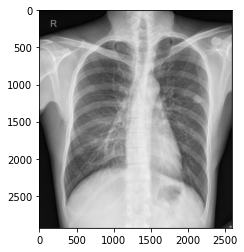

(128, 128, 3)


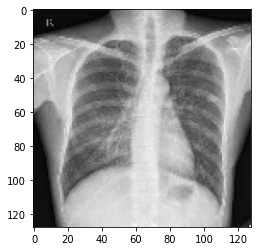

(2931, 2594, 1)


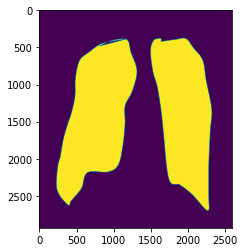

(128, 128, 1)


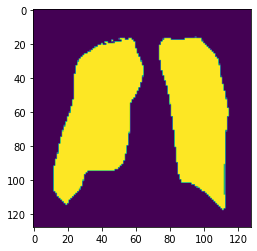

In [9]:
print(images[1].shape)
plt.imshow(images[1])
plt.show()

print(resized[1][0].shape)
plt.imshow(resized[1][0])
plt.show()

print(masks[1].shape)
plt.imshow(masks[1])
plt.show()

print(resized[1][1].shape)
plt.imshow(resized[1][1])
plt.show()

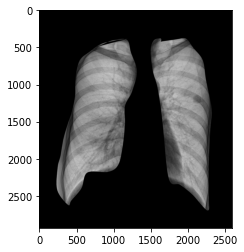

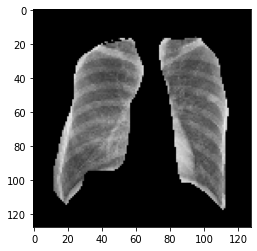

In [10]:
plt.imshow(masks[1]*images[1])
plt.show()
plt.imshow(resized[1][0]*resized[1][1])
plt.show()

### Implementing a train-test split. Not sure this is needed...

In [11]:
print(resized[0][0].shape,\
      resized[0][1].shape,\
      resized[0][2].shape,\
      resized[0][3].shape)

(128, 128, 3) (128, 128, 1) (128, 128, 3) (128, 128, 1)


200
200


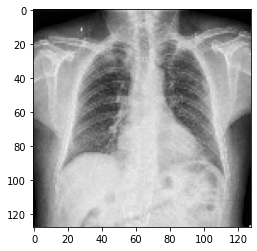

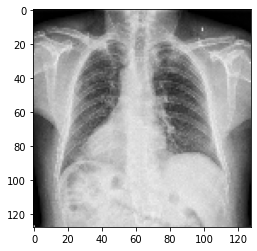

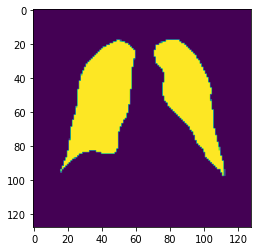

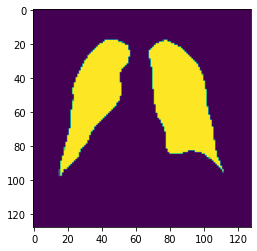

In [12]:
X_1 = [img_mask_pair[0] for img_mask_pair in resized]
X_2 = [img_mask_pair[2] for img_mask_pair in resized]

Y_1 = [img_mask_pair[1] for img_mask_pair in resized]
Y_2 = [img_mask_pair[3] for img_mask_pair in resized]

X = X_1 + X_2
Y = Y_1 + Y_2

X = np.array(X)
Y = np.array(Y)

# X = tuple(X)
# Y = tuple(Y)

print(len(X))
print(len(Y))

plt.imshow(X[10])
plt.show()

plt.imshow(X[110])
plt.show()

plt.imshow(Y[10])
plt.show()

plt.imshow(Y[110])
plt.show()

In [13]:
np.shape(X_1)
type(np.array(X_1))
type(X_1[0])

tensorflow.python.framework.ops.EagerTensor

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [15]:
print(X_test.shape, X_train.shape)
print(Y_test.shape, Y_train.shape)

(60, 128, 128, 3) (140, 128, 128, 3)
(60, 128, 128, 1) (140, 128, 128, 1)


### Using some stolen plotting-functions, etc.: [FUNCTIONALLY EMPTY/SHOULD DELETE/IGNORE]

In [16]:
# def display(display_list):
#   plt.figure(figsize=(15, 15))

#   title = ['Input Image', 'True Mask', 'Predicted Mask']

#   for i in range(len(display_list)):
#     plt.subplot(1, len(display_list), i+1)
#     plt.title(title[i])
#     plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
#     plt.axis('off')
#   plt.show()

### Defining the model (stolen direclty from <https://www.tensorflow.org/tutorials/images/segmentation>):

**Note**: The models in this section seem to want square images. So I will make them square. Currently, I see two "safe" ways to do this:

1. Utilizing the tensorflow-method tf.image.resize_with_pad, one can simply resize all images to squares by adding blank-space to make them square. This sounds innocuous, but will certainly increase the "class imbalance, which *could* be problematic.

2. Simply resizing the images to squares. This also has pros and cons. Pro: The class imbalances will remain fixed/minimally horrible. Con: It will distort the images, which may degrade image-recognition.

FYI: <https://www.tensorflow.org/api_docs/python/tf/image/resize_with_pad>

In [17]:
OUTPUT_CHANNELS = 1

**Important**: When the model _MobileNetV2_ is instantiated, _tensorflow_ gives error-messages unless two conditions are simulanteously met by the input_shape-parameter:

1. The input_shape is non-square. (We knew this. See above markup-cell.)
2. The input_shape is a square with dimensions other than (224, 224), (128, 128) etc. etc. The largest of these is (224, 224)-shape. But with (224, 224) there were problems --- maybe with the dimensionality of the "layer_names"-feature of the base_model (below). So I have chosen to futz that over to (128, 128)-shape for the time being...

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [58]:
print([base_model.get_layer(name) for name in layer_names])

[<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x14bd2dcd0>, <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x14bdaa490>, <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x14bdf82e0>, <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x14bec3940>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x14bf228b0>]


In [19]:
# from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 2, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Running the model (stolen directly and modified _zero_ (will it work at all??))...

In [21]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [25]:
TRAIN_LENGTH = len(X_test)
BATCH_SIZE = 5
BUFFER_SIZE = 10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [29]:
np.shape(X_train)

(140, 128, 128, 3)

In [30]:
Y_train.shape

(140, 128, 128, 1)

In [31]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(X_train, Y_train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=(X_test, Y_test)#,
#                           callbacks=[DisplayCallback()]
                         )

Epoch 1/50
12/12 [==============================] - 13s 854ms/step - loss: 0.6875 - accuracy: 0.6642 - val_loss: 0.3924 - val_accuracy: 0.8060
Epoch 2/50
12/12 [==============================] - 8s 697ms/step - loss: 0.3426 - accuracy: 0.8078 - val_loss: 0.2313 - val_accuracy: 0.9299
Epoch 3/50
12/12 [==============================] - 9s 751ms/step - loss: 0.2556 - accuracy: 0.8544 - val_loss: 0.1671 - val_accuracy: 0.9536
Epoch 4/50
12/12 [==============================] - 9s 741ms/step - loss: 0.1914 - accuracy: 0.9298 - val_loss: 0.1504 - val_accuracy: 0.9553
Epoch 5/50
12/12 [==============================] - 9s 739ms/step - loss: 0.1561 - accuracy: 0.9537 - val_loss: 0.1213 - val_accuracy: 0.9625
Epoch 6/50
12/12 [==============================] - 9s 736ms/step - loss: 0.1263 - accuracy: 0.9636 - val_loss: 0.1173 - val_accuracy: 0.9636
Epoch 7/50
12/12 [==============================] - 9s 742ms/step - loss: 0.1078 - accuracy: 0.9686 - val_loss: 0.1102 - val_accuracy: 0.9646
Epoch

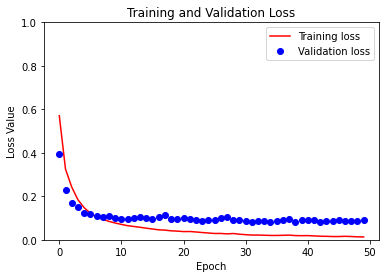

In [32]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Saving the model

In [60]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.4.1


In [61]:
from tensorflow.keras.models import load_model

model.save('model')  # creates a HDF5 file 'my_model.h5'

INFO:tensorflow:Assets written to: model/assets


In [63]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

In [67]:
200*128*128/(6.5*10**6)

0.5041230769230769

### Playing with the (very nice looking!) predicted-masks from the model:

In [35]:
futz_1 = np.array([[1,2,3],[5,7,11],[13,17,19]])
f1_s = futz_1.shape
futz_2 = np.reshape(futz_1, (3,3,-1))
f2_s = futz_2.shape
print(futz_1)
print(futz_1.shape)
print(futz_2)
print(futz_2.shape)

[[ 1  2  3]
 [ 5  7 11]
 [13 17 19]]
(3, 3)
[[[ 1]
  [ 2]
  [ 3]]

 [[ 5]
  [ 7]
  [11]]

 [[13]
  [17]
  [19]]]
(3, 3, 1)


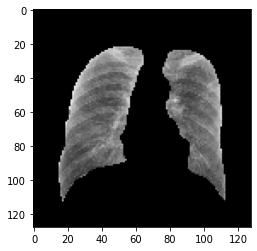

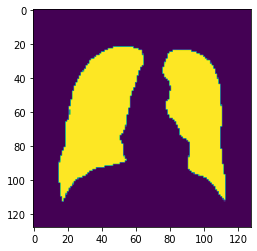

In [36]:
plt.imshow(X_test[1]*Y_test[1])
plt.show()

plt.imshow(Y_test[1])
plt.show()

In [37]:
print(Y_test[1].max())
print(Y_test[1].mean())
print(Y_test[1].min())

1.0
0.2746304
0.0


In [38]:
barnacle_1 = tf.image.resize(X_test[1], (128, 128))
print(type(barnacle_1))
print(barnacle_1.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(128, 128, 3)


In [42]:
clam_1 = model.predict(X_test[1][tf.newaxis, ...]).squeeze();
print(clam_1.max())
print(clam_1.mean())
print(clam_1.min())

11.261671
-3.256549
-12.0317955


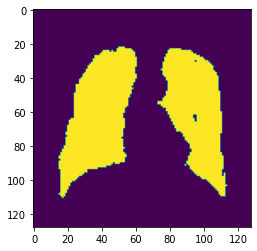

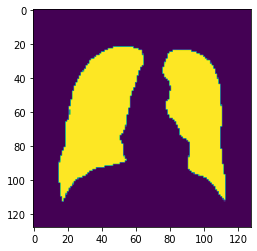

(128, 128)


In [45]:
clammy_1 = np.sign(clam_1)
plt.imshow(clammy_1)
plt.show()

plt.imshow(Y_test[1])
plt.show()

print(clammy_1.shape)

1.0
0.0
0.2677002


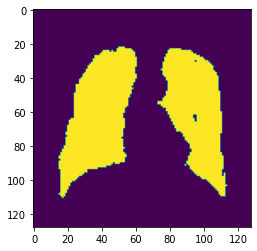

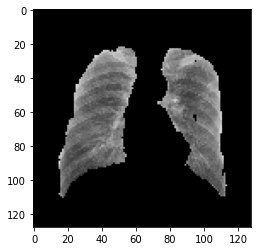

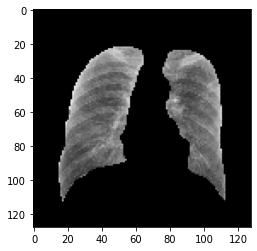

In [46]:
scallop_1 = (1+np.resize(clammy_1, (128, 128, 1)))/2
print(scallop_1.max())
print(scallop_1.min())
print(scallop_1.mean())
plt.imshow(scallop_1)
plt.show()
plt.imshow(scallop_1*X_test[1])
plt.show()
plt.imshow(Y_test[1]*X_test[1])
plt.show()

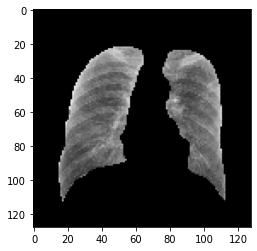

(128, 128, 1)


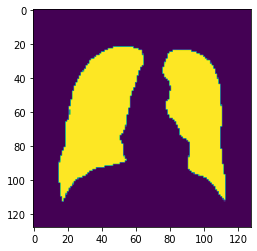

(128, 128)


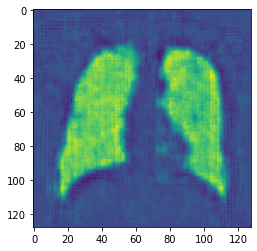

<class 'numpy.ndarray'>


In [47]:
plt.imshow(X_test[1]*Y_test[1])
plt.show()

print(Y_test[1].shape)

plt.imshow(Y_test[1])
plt.show()

print(model.predict(X_test[1][tf.newaxis, ...]).squeeze().shape)

plt.imshow( model.predict(X_test[1][tf.newaxis, ...]).squeeze() )
plt.show()

print(type(model.predict(X_test[1][tf.newaxis, ...]).squeeze()) )

In [48]:
X_test[1][tf.newaxis, ...].shape

(1, 128, 128, 3)

In [49]:
create_mask(model.predict(X_test[1][tf.newaxis, ...]))

<tf.Tensor: shape=(1, 128, 128), dtype=int64, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])>

In [50]:
X_test[1].shape

(128, 128, 3)

In [53]:
clams = model.predict(X_test[1][tf.newaxis, ...])
print(clams.shape)
print(type(clams))
# plt.imshow(clams)

(1, 128, 128, 1)
<class 'numpy.ndarray'>


In [54]:
print(Y_test[1].shape)
print(type(Y_test[1]))

(128, 128, 1)
<class 'numpy.ndarray'>


In [59]:
X_test[1].shape

(128, 128, 3)

### Complete run-through? If this 1+1-cell executes, we know.

In [56]:
1+1

2